In [36]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample

In [37]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24/"
nbqx_export_summary = data_dir + "export_summary_backup.csv"

camera_program = 4
um_per_px = 6.0 #um

In [38]:
# load CSV of all L4 and L2/3 crossing with NBQX blockade (array only CSV)
crossing_data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
crossing_data = pd.read_csv(crossing_data_dir + 'export_summary_crossing_PPR_array_only.csv')

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

crossing_data

,Layer,drug,Date,Slice,Location,Recording,amp_array,ROI file,snr_array
0,L4,ACSF,12/9/2024,2,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
1,L4,NBQX,12/9/2024,2,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
2,L4,ACSF,10/29/2024,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
3,L4,NBQX,10/29/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
4,L2/3,ACSF,10/23/2024,1,2,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
5,L2/3,NBQX,10/23/2024,1,2,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
6,L2/3,ACSF,6/26/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...
7,L2/3,NBQX,6/26/2024,1,1,4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...
8,L2/3,ACSF,7/1/2024,3,2,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...
9,L2/3,NBQX,7/1/2024,3,2,5,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...


C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-09-24/converted_zda/_2_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-09-24/converted_zda/_2_3_1_snr_array_.dat


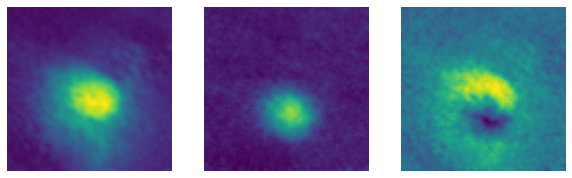

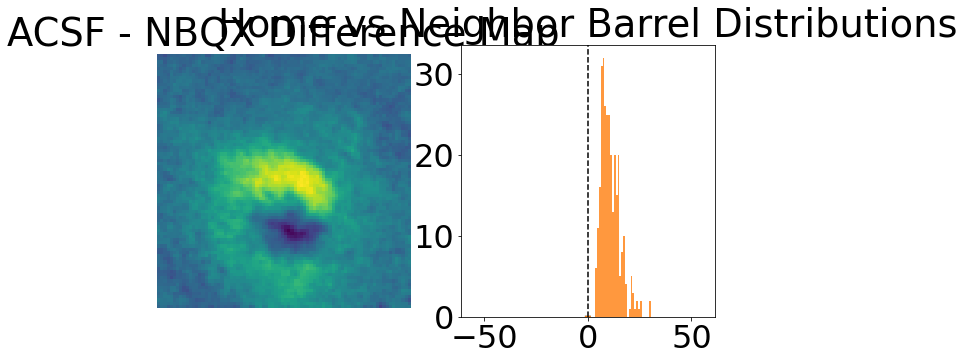

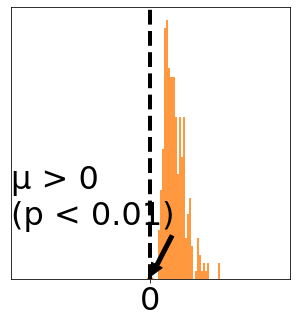

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-29-24\selected_zda/_1_1_3_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-29-24\selected_zda/_1_2_1_snr_array_.dat


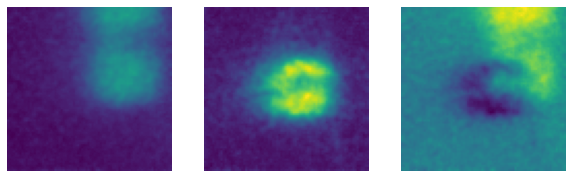

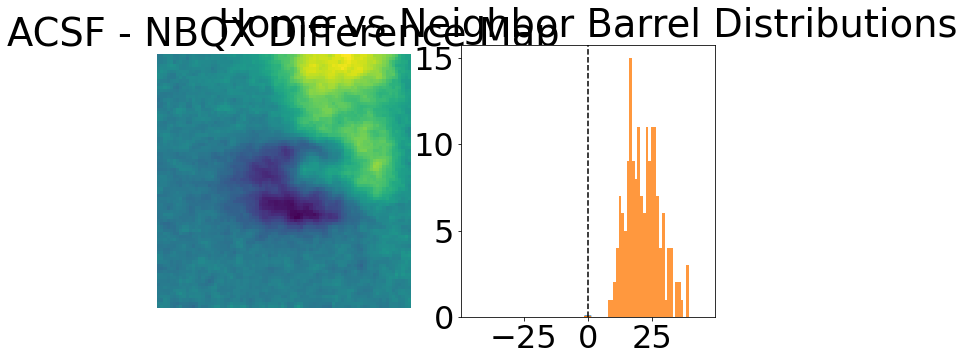

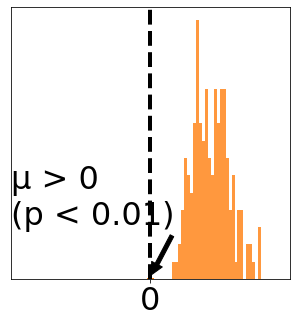

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-17-24/_3_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-17-24/_3_1_5_snr_array_.dat


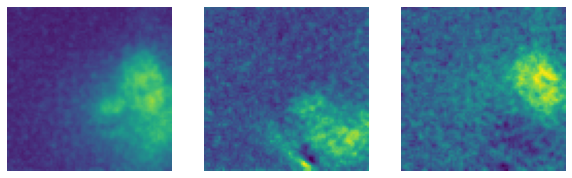

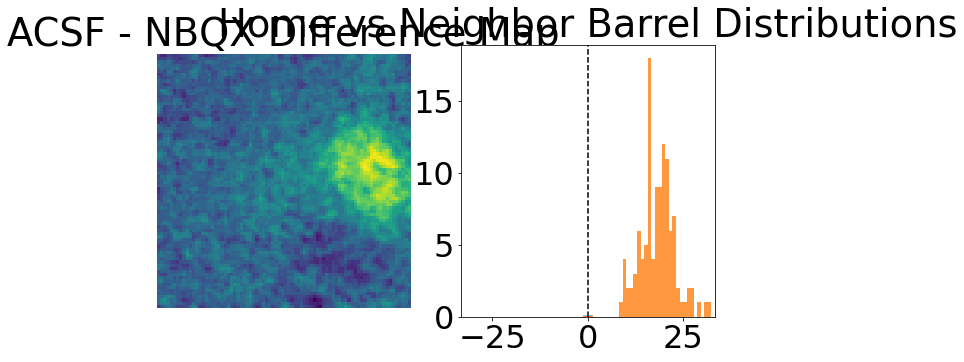

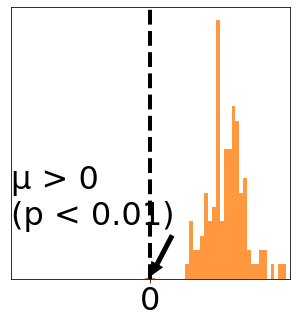

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_2_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_2_3_2_snr_array_.dat


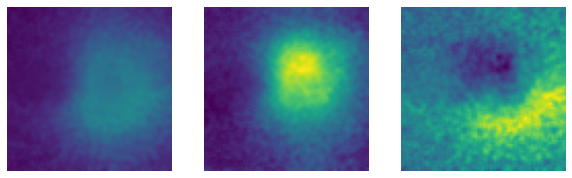

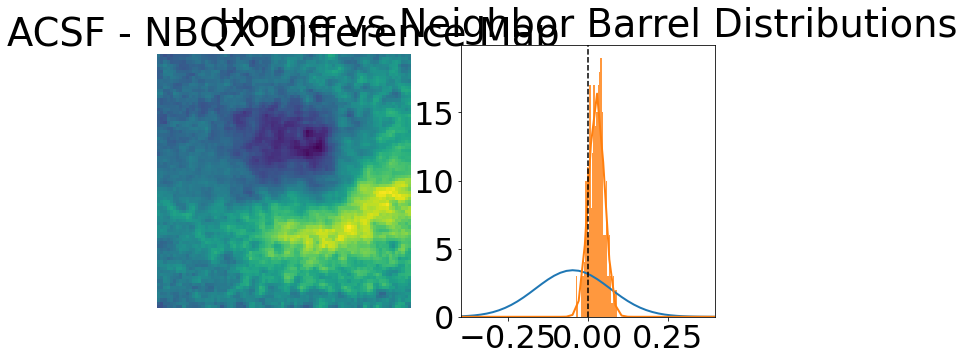

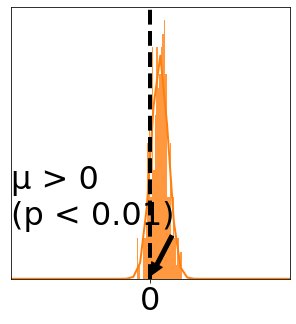

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_3_2_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_3_4_2_snr_array_.dat


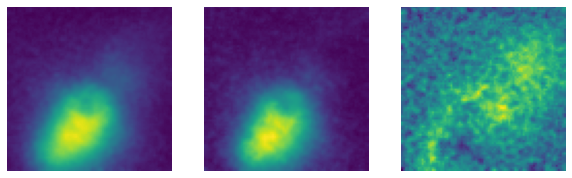

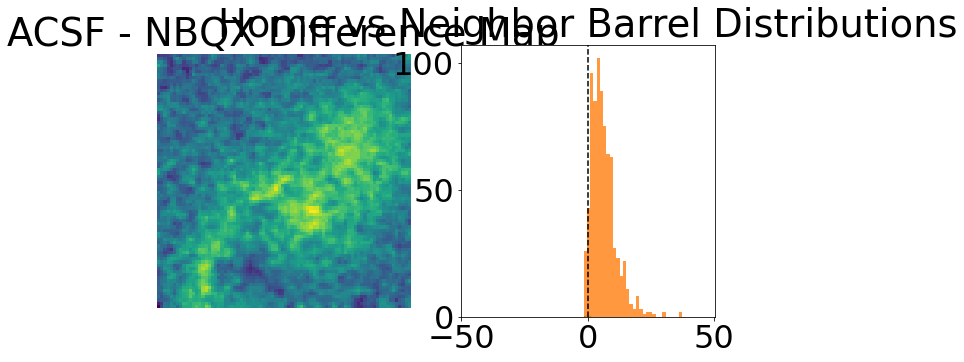

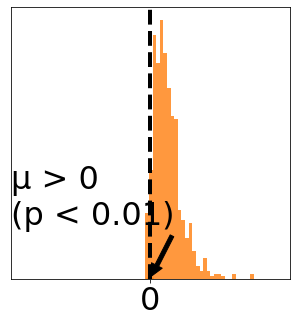

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-18-24/selected_zda/_2_1_2_snr_array_2_rois.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-18-24/selected_zda/_2_3_1_snr_array_2_rois.dat


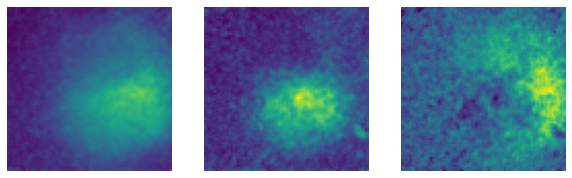

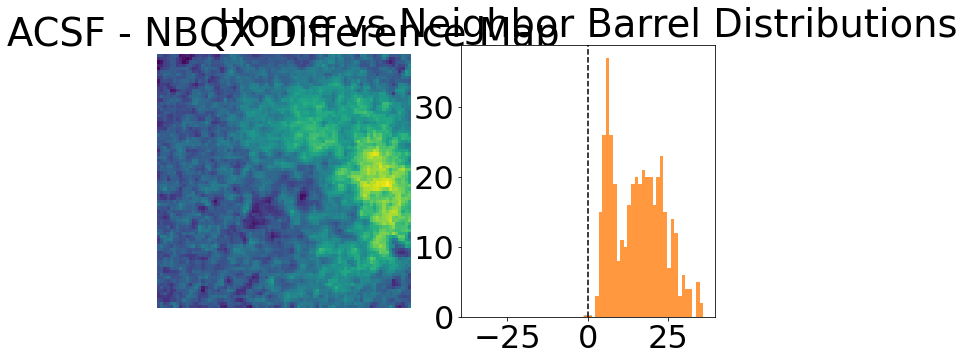

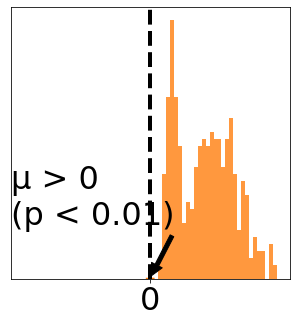

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-23-24\selected_zda/_1_2_3_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-23-24\selected_zda/_1_2_4_snr_array_.dat


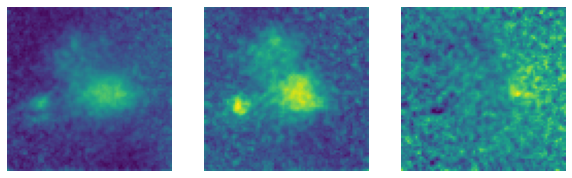

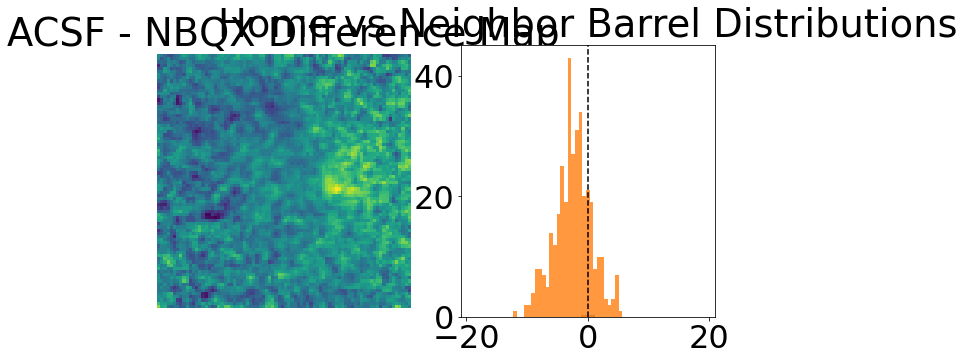

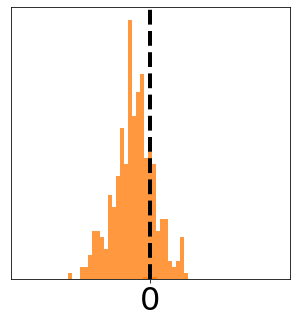

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/06-26-24/_1_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/06-26-24/_1_1_4_snr_array_.dat


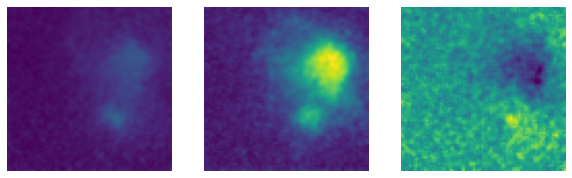

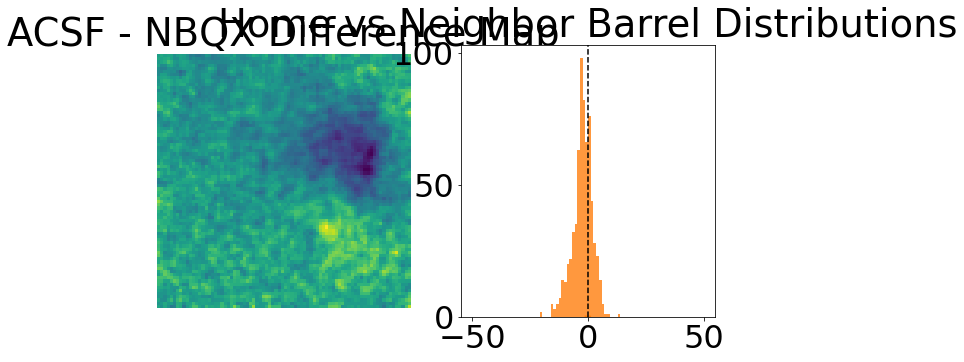

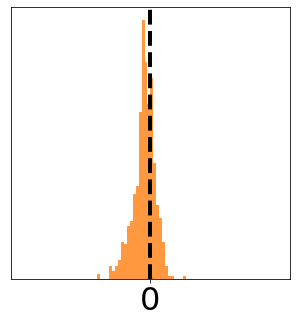

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_3_2_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_3_2_5_snr_array_.dat


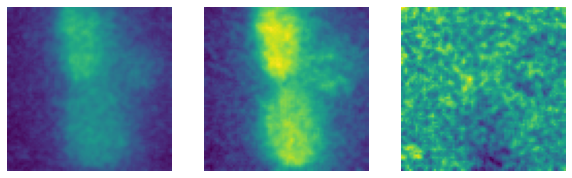

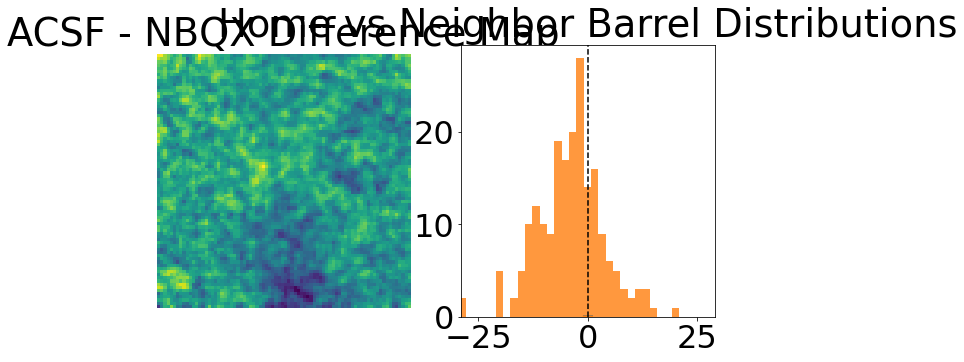

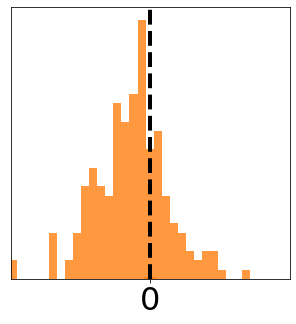

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_4_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_4_1_4_snr_array_.dat


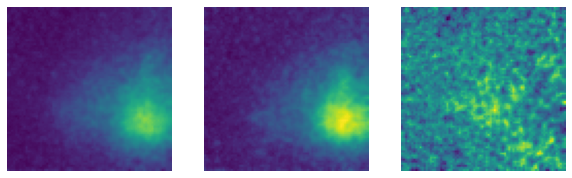

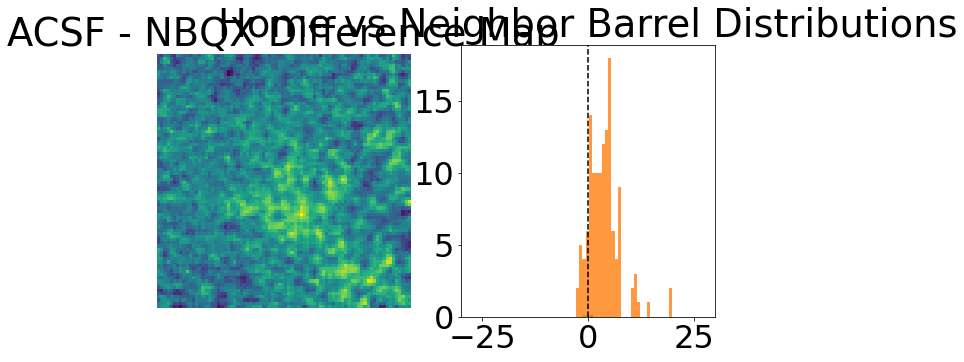

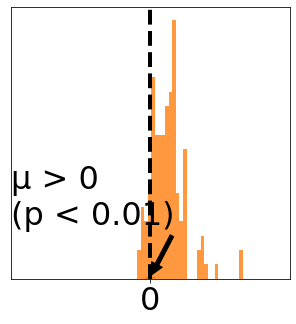

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-15-24/_2_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-15-24/_2_1_5_snr_array_.dat


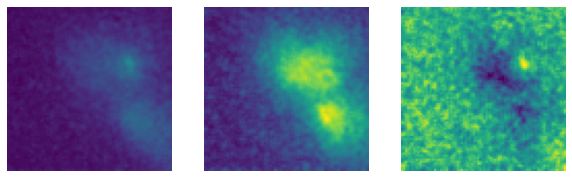

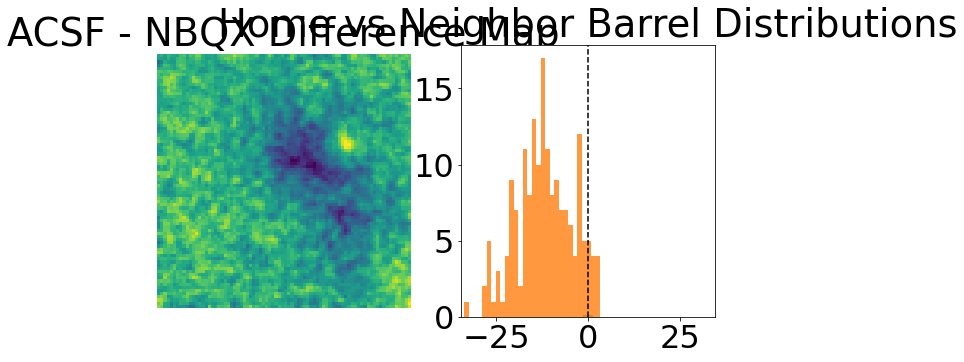

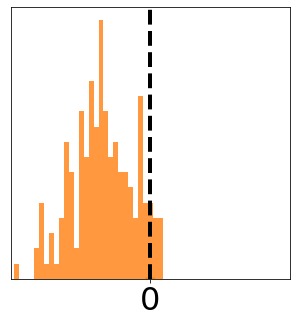

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-20-24/converted_zda/_1_3_1_snr_array_1_rois.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-20-24/converted_zda/_1_3_2_snr_array_1_rois.dat


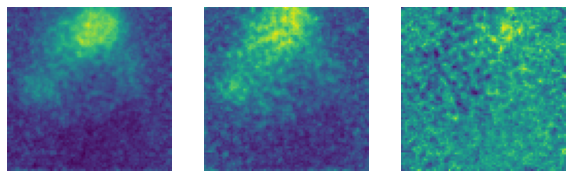

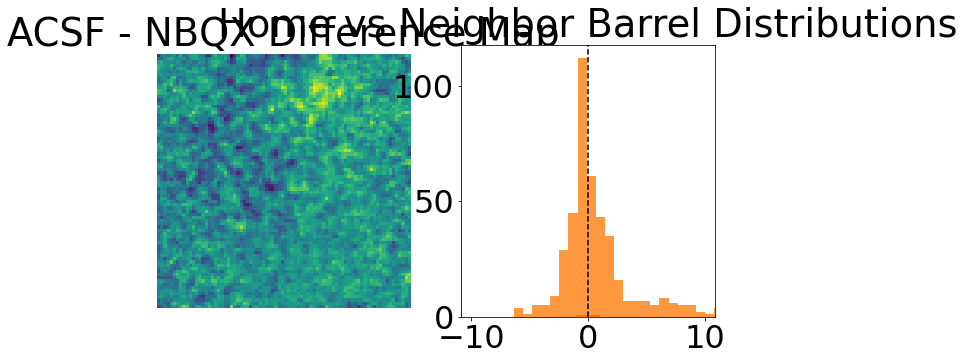

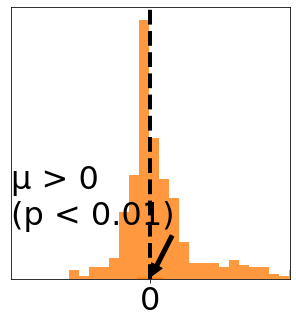

In [39]:
# set matplotlib font size
plt.rcParams.update({'font.size': 32})

# load the array files for each cell
survival_percentile = 70
surviving_pixels = {'L4': {'home': [], 'neighbor': []}, 
                    'L2/3': {'home': [], 'neighbor': []}}
before_pixels = {'L4': {'home': [], 'neighbor': []},
                    'L2/3': {'home': [], 'neighbor': []}}
delta_mins = {'L4': [], 'L2/3': []}
delta_maxs = {'L4': [], 'L2/3': []}
delta_mins_by_barrel = {'L4': {'home': [], 'neighbor': []},
                    'L2/3': {'home': [], 'neighbor': []}}
delta_maxs_by_barrel = {'L4': {'home': [], 'neighbor': []},
                    'L2/3': {'home': [], 'neighbor': []}}
for layer in crossing_data['Layer'].unique():
    layer_df = crossing_data[crossing_data['Layer'] == layer]
    for date in layer_df['Date'].unique():
        date_df = layer_df[layer_df['Date'] == date]
        for slic in date_df['Slice'].unique():
            slic_df = date_df[date_df['Slice'] == slic]

            fig, ax = plt.subplots(1, 3, figsize=(10, 5))
            amp_arrays = {}
            snr_arrays = {}
            amp_arrays_no_norm = {}

            # normalize each pair of arrays to the same scale
            pair_arrays = {}
            for drug in slic_df['drug'].unique():
                drug_df = slic_df[slic_df['drug'] == drug]
                amp_array = drug_df['amp_array'].values[0]
                snr_array = drug_df['snr_array'].values[0]
                amp_array_no_norm = amp_array[:-4] + 'no_norm.dat'

                amp_array = read_array_file(amp_array)
                i_drug = 0 if drug == 'ACSF' else 1
                amp_arrays[drug] = amp_array

                print(snr_array)
                snr_array = read_array_file(snr_array)
                amp_array_no_norm = read_array_file(amp_array_no_norm)
                amp_arrays_no_norm[drug] = amp_array_no_norm

                snr_arrays[drug] = snr_array
                pair_arrays[i_drug] = amp_array_no_norm

            pair_min = min([np.min(arr) for arr in pair_arrays.values()])
            pair_max = max([np.max(arr) for arr in pair_arrays.values()])
            for i_d, arr in enumerate(pair_arrays.values()):
                ax[i_d].imshow(arr, vmin=pair_min, vmax=pair_max)

            # get the difference between the two arrays
            diff_array = amp_arrays['ACSF'] - amp_arrays['NBQX']
            diff_snr_array = snr_arrays['ACSF'] - snr_arrays['NBQX']
            diff_array_no_norm = amp_arrays_no_norm['ACSF'] - amp_arrays_no_norm['NBQX']
            ax[2].imshow(diff_array)
            #ax[1].set_title(layer + '   ' + date + '    Slice ' + str(slic))

            # turn off spines
            for a in ax:
                a.axis('off')

            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_arrays.png')
            plt.show()

            # roi file loading
            roi_file = slic_df['ROI file'].values[0]

            # read in the ROI file
            rois = ROIFileReader(roi_file).get_roi_list()

            # convert from diode to pixel
            rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in rois]

            # first roi is home barrel, rest are neighboring barrels
            home_barrel = rois[0]
            neighbor_barrels = rois[1:]

            # get the survival_percentile% percentile of the ACSF array
            acsf_survive = np.percentile(amp_arrays['ACSF'], survival_percentile)

            # how much of the NBQX array is above the survival_percentile of the ACSF array
            nbqx_above_acsf = amp_arrays['NBQX'] > acsf_survive
            acsf_before = amp_arrays['ACSF'] > acsf_survive
            
            # count the number of pixels above the 95th percentile of the ACSF array in the home barrel
            home_ct = 0
            home_ct_control = 0
            for point in home_barrel:
                x, y = point
                home_ct += nbqx_above_acsf[y, x]
                home_ct_control += acsf_before[y, x]
            surviving_pixels[layer]['home'].append(home_ct)
            before_pixels[layer]['home'].append(home_ct_control)

            # count the number of pixels above the 95th percentile of the ACSF array in the neighbor barrels
            neighbor_ct = 0
            neighbor_ct_control = 0
            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neighbor_ct += nbqx_above_acsf[y, x]
                    neighbor_ct_control += acsf_before[y, x]
            surviving_pixels[layer]['neighbor'].append(neighbor_ct)
            before_pixels[layer]['neighbor'].append(neighbor_ct_control)

            # build the ACSF -> NBQX percent change map
            percent_change_map = np.zeros_like(amp_arrays['ACSF'])
            percent_change_map[amp_arrays['ACSF'] > 0] = (amp_arrays['NBQX'][amp_arrays['ACSF'] > 0] 
                    - amp_arrays['ACSF'][amp_arrays['ACSF'] > 0]) / amp_arrays['ACSF'][amp_arrays['ACSF'] > 0]

            home_barrel_distribution = []
            neighbor_barrel_distribution = []

            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neighbor_barrel_distribution.append(diff_snr_array[y, x])

            for point in home_barrel:
                x, y = point
                home_barrel_distribution.append(diff_snr_array[y, x])

            # fit a normal distribution to the home barrel and neighbor barrel distributions
            home_barrel_distribution = np.array(home_barrel_distribution)
            neighbor_barrel_distribution = np.array(neighbor_barrel_distribution)
            home_mean, home_std = norm.fit(home_barrel_distribution)
            neighbor_mean, neighbor_std = norm.fit(neighbor_barrel_distribution)

            # plot ratio map and home/neighbor barrel distributions
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(diff_array)
            ax[0].set_title('ACSF - NBQX Difference Map')
            ax[0].axis('off')
            #ax[1].hist(home_barrel_distribution, bins=30, alpha=0.8, label='Home Barrel')
            ax[1].hist(neighbor_barrel_distribution, bins=30, alpha=0.8, label='Neighbor Barrel', color='tab:orange')

            # set the x-axis limits to min-max of histogram
            hist_max = max(-min(home_mean - 3 * home_std, neighbor_mean - 3 * neighbor_std), 
                            max(home_mean + 3 * home_std, neighbor_mean + 3 * neighbor_std))
            #hist_max = 50
            ax[1].set_xlim(-hist_max, hist_max)

            # plot the normal distributions
            x = np.linspace(-0.95, 0.95, 100)
            y_home = norm.pdf(x, home_mean, home_std)
            y_neighbor = norm.pdf(x, neighbor_mean, neighbor_std)
            ax[1].plot(x, y_home, 'tab:blue', linewidth=2)
            ax[1].plot(x, y_neighbor, 'tab:orange', linewidth=2)
            #ax[1].set_xlim(-0.95, 0.95)

            # vertical black line at 0
            ax[1].axvline(x=0, color='black', linestyle='--')

            ax[1].set_title('Home vs Neighbor Barrel Distributions')
            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_distributions.png')
            plt.show()

            # make a separate plot of just the neighbor histogram with no spines
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.hist(neighbor_barrel_distribution, bins=30, alpha=0.8, label='Neighbor Barrel', color='tab:orange')
            ax.plot(x, y_neighbor, 'tab:orange', linewidth=2)
            ax.set_xlim(-hist_max, hist_max)
            ax.axvline(x=0, color='black', linestyle='--', linewidth=4)

            # significance testing: is the neighbor barrel distribution less than a distibution with mean 0?
            t, p = ttest_ind(neighbor_barrel_distribution, 
                            np.random.normal(loc=0, scale=np.std(neighbor_barrel_distribution), size=len(neighbor_barrel_distribution)),
                            equal_var=True,
                            alternative='greater')
            if p < 0.01:
                # annotate the p-value as a star above the distribution mean
                ax.annotate('µ > 0 \n(p < 0.01)', xy=(0, 0.1), xytext=(0, 0.2), textcoords='axes fraction',
                                arrowprops=dict(facecolor='black', shrink=0.05))

            ax.set_xticks([0])
            ax.set_yticks([])
            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_neighbor_distribution.png')
            plt.show()

            # save the absolute mins and maxs of the difference map
            delta_mins[layer].append(np.min(diff_array_no_norm))
            delta_maxs[layer].append(np.max(diff_array_no_norm))

            # save the mins and maxs of the difference map by barrel
            neigh_min = np.Inf
            neigh_max = -np.Inf
            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neigh_min = min(neigh_min, diff_array_no_norm[y, x])
                    neigh_max = max(neigh_max, diff_array_no_norm[y, x])

            home_min = np.Inf
            home_max = -np.Inf
            for point in home_barrel:
                x, y = point
                home_min = min(home_min, diff_array_no_norm[y, x])
                home_max = max(home_max, diff_array_no_norm[y, x])

            delta_mins_by_barrel[layer]['home'].append(home_min)
            delta_maxs_by_barrel[layer]['home'].append(home_max)
            delta_mins_by_barrel[layer]['neighbor'].append(neigh_min)
            delta_maxs_by_barrel[layer]['neighbor'].append(neigh_max)

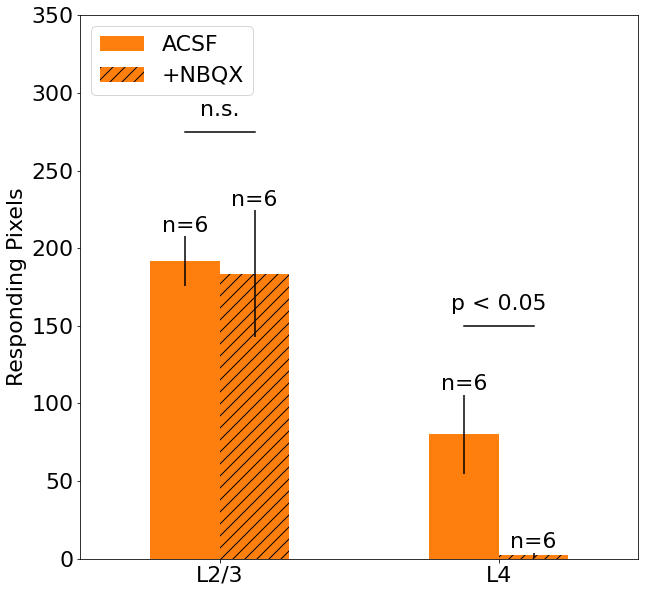

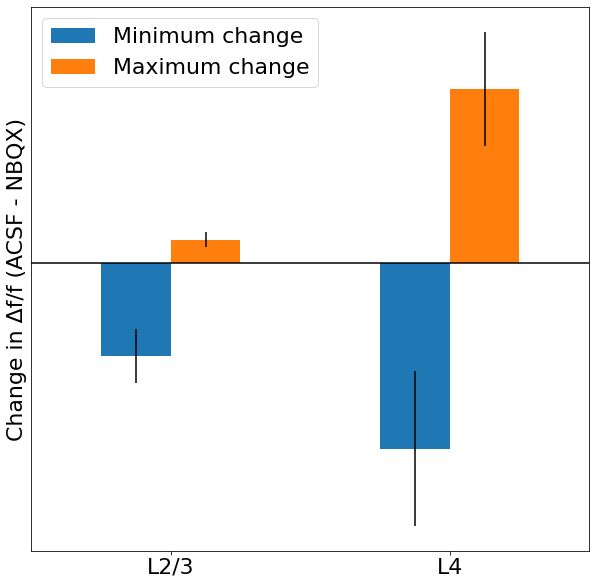

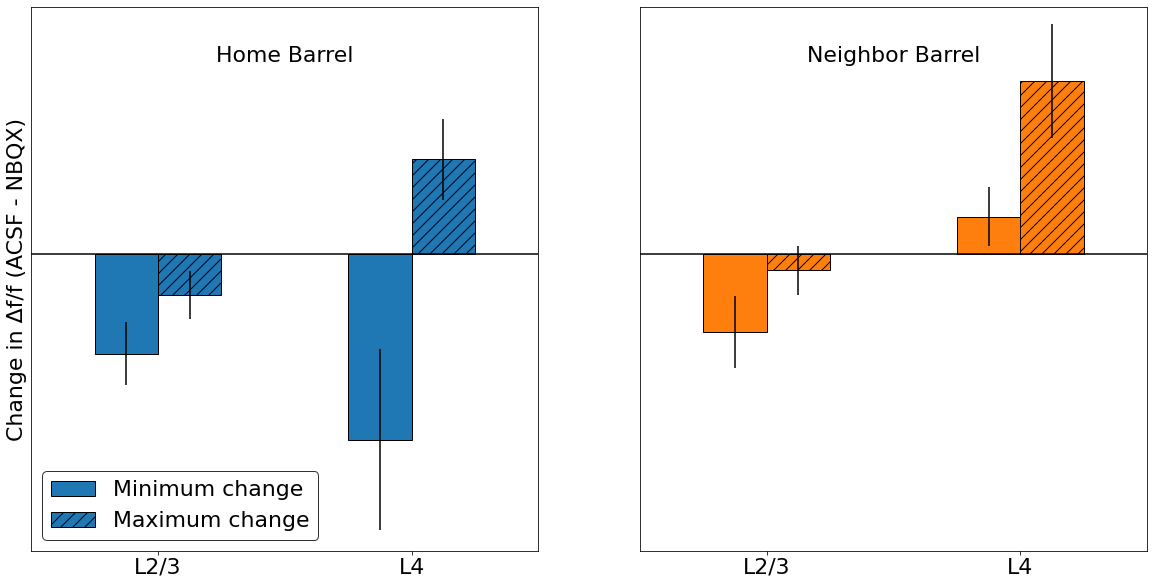

In [40]:
# set matplotlib font size
plt.rcParams.update({'font.size': 22})

# bar plot of surviving pixels, L2/3 vs L4, with error bars
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layers = ['L2/3', 'L4']

surviving_pixels_mean = [np.mean(surviving_pixels[layer]['home']) for layer in layers]
surviving_pixels_sem = [sem(surviving_pixels[layer]['home']) for layer in layers]
#ax.bar([-.125, .875], surviving_pixels_mean, yerr=surviving_pixels_sem, width=.25, label='Home Barrel')

before_pixels_mean = [np.mean(before_pixels[layer]['neighbor']) for layer in layers]
before_pixels_sem = [sem(before_pixels[layer]['neighbor']) for layer in layers]
ax.bar([-.125, .875], before_pixels_mean, yerr=before_pixels_sem, width=.25, label='ACSF', color='tab:orange')

surviving_pixels_mean = [np.mean(surviving_pixels[layer]['neighbor']) for layer in layers]
surviving_pixels_sem = [sem(surviving_pixels[layer]['neighbor']) for layer in layers]
ax.bar([.125, 1.125], surviving_pixels_mean, yerr=surviving_pixels_sem, width=.25, label='+NBQX', hatch='//', color='tab:orange')
ax.set_ylabel('Responding Pixels')

ax.set_xticks([0, 1])
ax.set_xticklabels(layers)
ax.set_xlim(-.5, 1.5)

# annotate sample size on each layer/drug bar
bar_locs = [-.125, .125, .875, 1.125]
for i, layer in enumerate(layers):
    for j, drug in enumerate(['ACSF', 'NBQX']):
        if drug == 'ACSF':
            drug_dict = before_pixels
        else:
            drug_dict = surviving_pixels

        ax.text(bar_locs[i*2 + j], np.mean(drug_dict[layer]['neighbor']) + sem(drug_dict[layer]['neighbor']) + 3, 
                'n=' + str(len(drug_dict[layer]['neighbor'])), ha='center')

bar_height = [275, 150]
# significance testing: ACSF vs NBQX
for i, layer in enumerate(layers):
    t_stat, p_val = ttest_ind(before_pixels[layer]['neighbor'], surviving_pixels[layer]['neighbor'])
    if p_val < 0.05:
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'p < 0.05', ha='center')

        # add line between home and neighbor barrel
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
    else:
        # add n.s. bar
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'n.s.', ha='center')

'''for i, layer in enumerate(layers):
    for j, barrel in enumerate(['home', 'neighbor']):
        ax.text(bar_locs[i*2 + j], np.mean(surviving_pixels[layer][barrel]) + sem(surviving_pixels[layer][barrel]) + 3, 
                'n=' + str(len(surviving_pixels[layer][barrel])), ha='center')

bar_height = [355, 390]
# significance testing: home vs neighbor barrel
for i, layer in enumerate(layers):
    t_stat, p_val = ttest_ind(surviving_pixels[layer]['home'], surviving_pixels[layer]['neighbor'])
    if p_val < 0.01:
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'p < 0.05', ha='center')

        # add line between home and neighbor barrel
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
    else:
        # add n.s. bar
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'n.s.', ha='center')'''
        
# legend in top left
ax.set_ylim(0, 350)
ax.legend(loc='upper left')
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/surviving_pixels.png')
plt.show()

####### bar plot of absolute mins and maxs of the difference map ############
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layers = ['L2/3', 'L4']
delta_min_mean = [np.mean(delta_mins[layer]) for layer in layers]
delta_min_sem = [sem(delta_mins[layer]) for layer in layers]
ax.bar([-.125, .875], delta_min_mean, yerr=delta_min_sem, width=.25, label='Minimum change')

delta_max_mean = [np.mean(delta_maxs[layer]) for layer in layers]
delta_max_sem = [sem(delta_maxs[layer]) for layer in layers]
ax.bar([.125, 1.125], delta_max_mean, yerr=delta_max_sem, width=.25, label='Maximum change')

ax.set_ylabel('Change in Δf/f (ACSF - NBQX)') 
ax.set_xticks([0, 1])
ax.set_xticklabels(layers)
ax.set_xlim(-.5, 1.5)
ax.set_yticks([])

# horizontal line at 0
ax.axhline(y=0, color='black')

# save and show the plot
ax.legend(loc='upper left')
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/delta_min_max.png')
plt.show()


####### bar plot of absolute mins and maxs of the difference map by barrel ############
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
layers = ['L2/3', 'L4']

# home barrel in the left plot
delta_min_mean = [np.mean(delta_mins_by_barrel[layer]['home']) for layer in layers]
delta_min_sem = [sem(delta_mins_by_barrel[layer]['home']) for layer in layers]
ax[0].bar([-.125, .875], delta_min_mean, yerr=delta_min_sem, width=.25, label='Minimum change', edgecolor='black', color='tab:blue')

delta_max_mean = [np.mean(delta_maxs_by_barrel[layer]['home']) for layer in layers]
delta_max_sem = [sem(delta_maxs_by_barrel[layer]['home']) for layer in layers]
ax[0].bar([.125, 1.125], delta_max_mean, yerr=delta_max_sem, width=.25, label='Maximum change', edgecolor='black', color='tab:blue', hatch='//')

ax[0].set_ylabel('Change in Δf/f (ACSF - NBQX)')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(layers)
ax[0].set_xlim(-.5, 1.5)

# horizontal line at 0
ax[0].axhline(y=0, color='black')

# neighbor barrel in the right plot
delta_min_mean = [np.mean(delta_mins_by_barrel[layer]['neighbor']) for layer in layers]
delta_min_sem = [sem(delta_mins_by_barrel[layer]['neighbor']) for layer in layers]
ax[1].bar([-.125, .875], delta_min_mean, yerr=delta_min_sem, width=.25, label='Minimum change', edgecolor='black', color='tab:orange')

delta_max_mean = [np.mean(delta_maxs_by_barrel[layer]['neighbor']) for layer in layers]
delta_max_sem = [sem(delta_maxs_by_barrel[layer]['neighbor']) for layer in layers]
ax[1].bar([.125, 1.125], delta_max_mean, yerr=delta_max_sem, width=.25, label='Maximum change', edgecolor='black', color='tab:orange', hatch='//')

ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(layers)
ax[1].set_xlim(-.5, 1.5)

# horizontal line at 0
ax[1].axhline(y=0, color='black')

# annotate left as home and right as neighbor within the plot
ax[0].text(0.5, 0.9, 'Home Barrel', ha='center', transform=ax[0].transAxes)
ax[1].text(0.5, 0.9, 'Neighbor Barrel', ha='center', transform=ax[1].transAxes)

# set left and right plots to share the same y-scale. Pull current y-axis limits and set the same for both plots
y_min = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])
y_max = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].legend(loc='lower left', labelcolor='black', facecolor='white', edgecolor='black')

# save and show the plot
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/delta_min_max_by_barrel.png')
plt.show()

In [41]:
# read in hw/lat/amp data
data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df

,Layer,drug,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace
0,L4,NBQX,1,1.208980,44.28930,1.1323,8.08166,50.551020,51.918367,1_rois,11/6/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
1,L4,ACSF,2,0.330953,6.90515,3.4924,26.12920,66.867374,28.713528,1_rois,11/6/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
2,L4,NBQX,1,1.774300,75.77820,1.2188,4.78006,50.551020,51.918367,1_rois,11/6/2024,1,1,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
3,L4,ACSF,2,0.325975,7.08423,2.3590,5.69864,66.867374,28.713528,1_rois,11/6/2024,1,1,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
4,L4,NBQX,1,1.488840,68.13480,1.6920,6.25805,55.466877,41.141956,1_rois,12/9/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
5,L4,ACSF,2,0.983708,39.26490,4.9494,12.78330,29.060606,33.034091,1_rois,12/9/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
6,L4,NBQX,1,0.000000,0.00000,NaN,6.25805,55.466877,41.141956,1_rois,12/9/2024,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
7,L4,ACSF,2,0.053680,1.00786,5.2739,2.54030,29.060606,33.034091,1_rois,12/9/2024,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
8,L4,NBQX,1,14.255900,56.77760,1.5938,8.15259,40.464912,49.561404,2_rois,12/9/2024,2,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
9,L4,ACSF,2,3.041910,23.21550,2.3892,15.21730,51.851974,29.101974,2_rois,12/9/2024,2,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


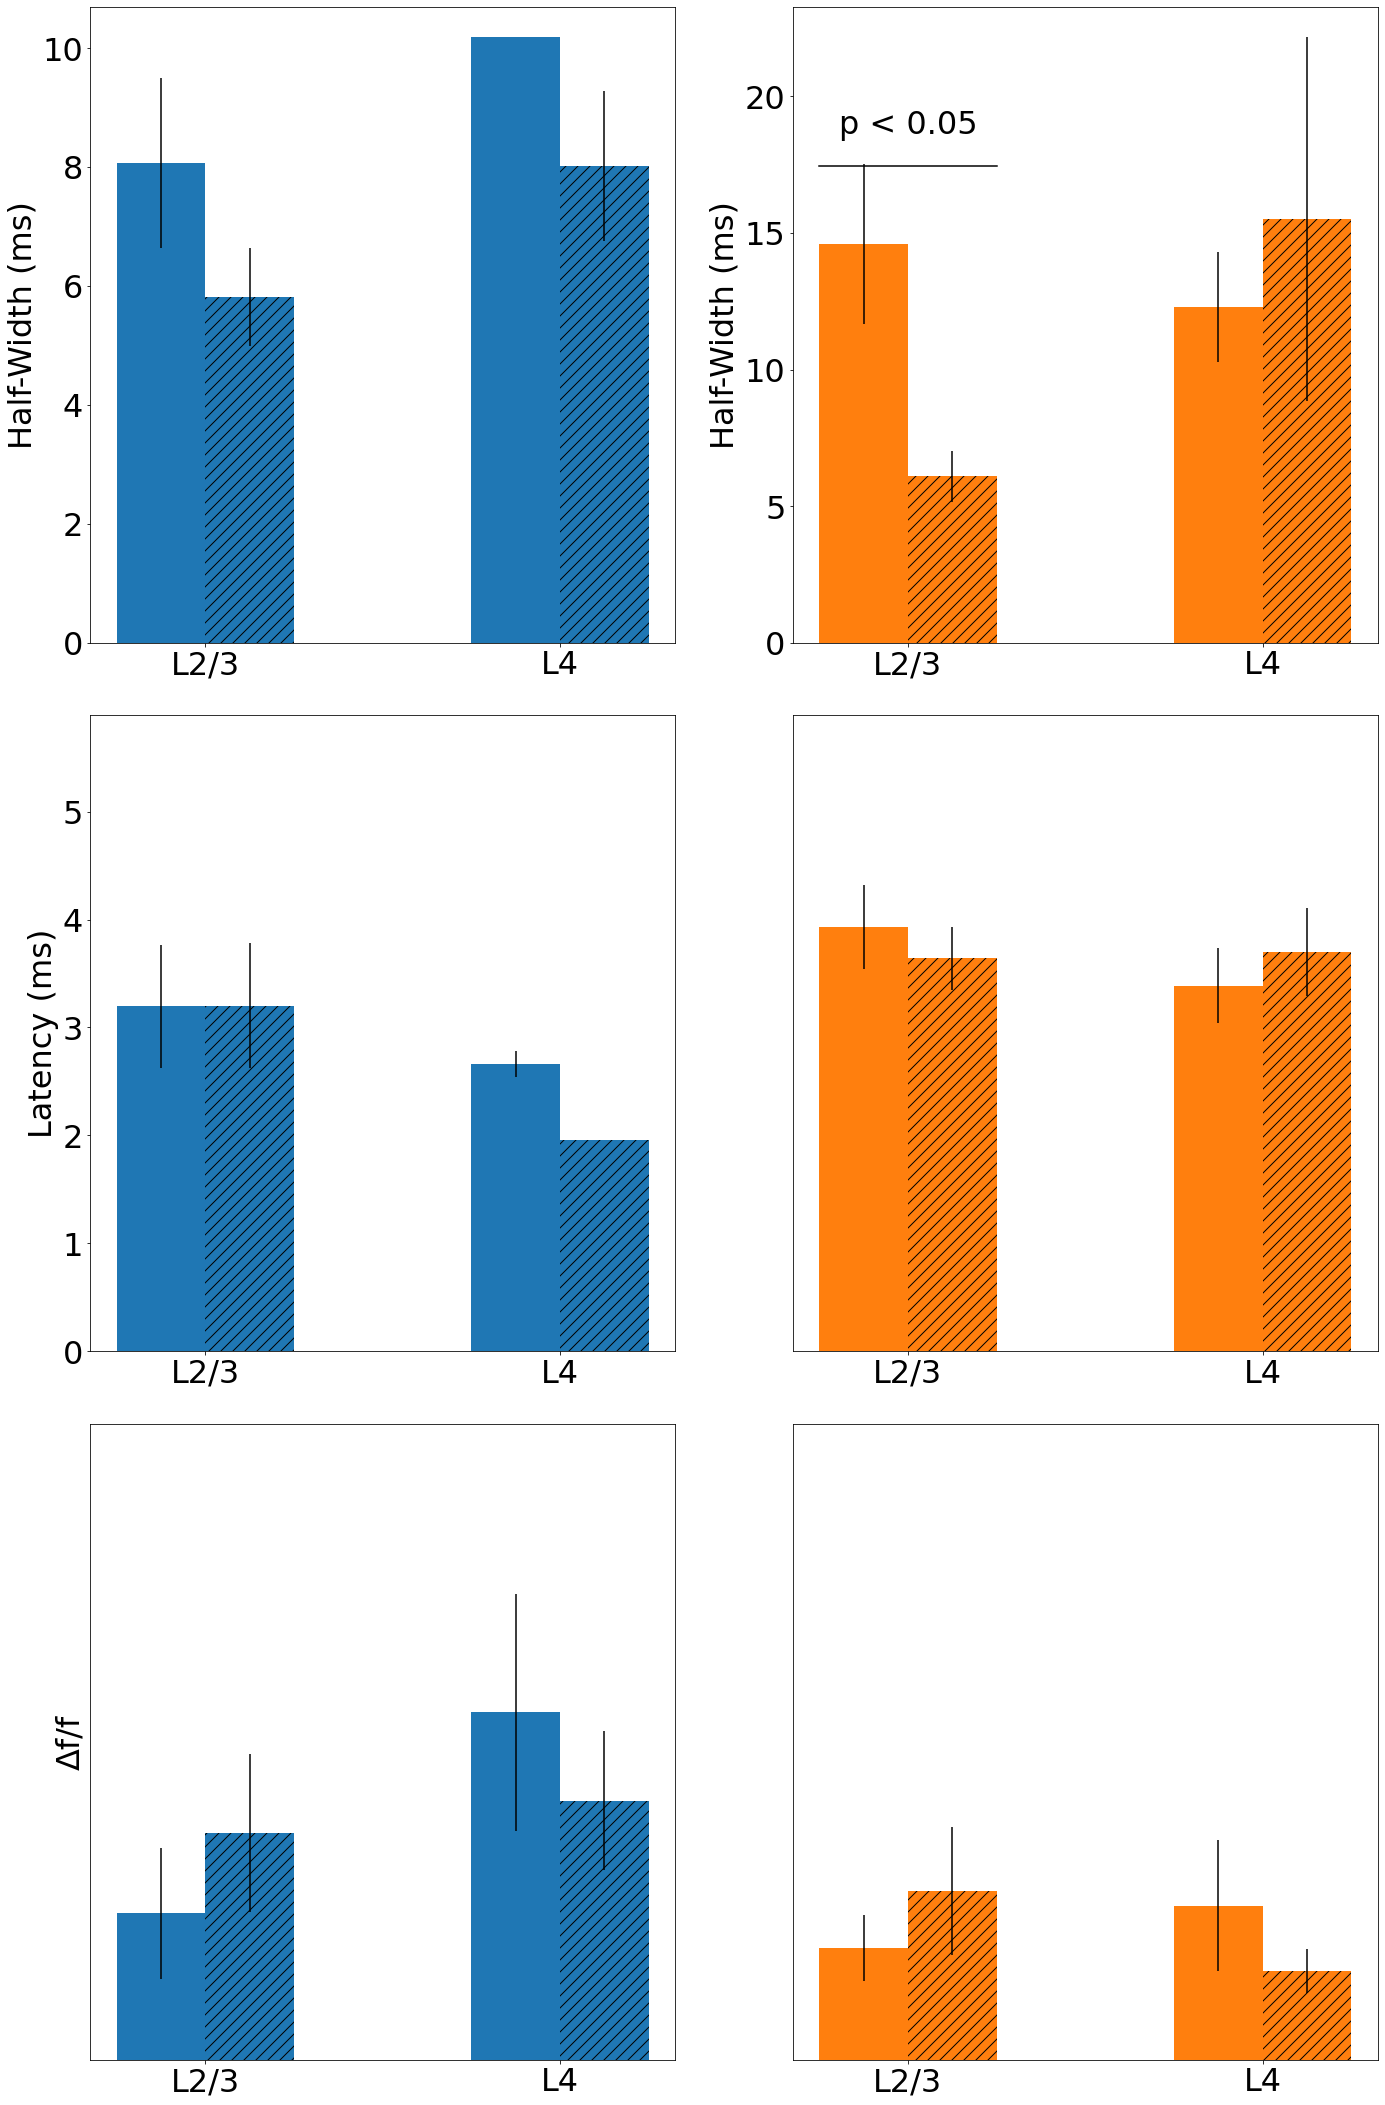

In [42]:
# plot the data, comparing L2/3 to L4 and ACSF to NBQX and home (ROI == 1) to neighbor (ROI > 1)

# font size
plt.rcParams.update({'font.size': 32})

fig, ax = plt.subplots(3, 2, figsize=(20, 30))
layers = ['L2/3', 'L4']
drug = ['ACSF', 'NBQX']

handles = []
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        
        hatch = '//' if d == 'NBQX' else None
        for roi in [1, 2]:
            col = 'tab:blue' if roi == 1 else 'tab:orange'
            roi_df = hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == d) & (hw_lat_df['ROI'] == roi)]
            l = ax[0][roi-1].bar([i + j/4-.125], np.mean(roi_df['halfwidth']), yerr=sem(roi_df['halfwidth']), label=drug, width=.25, color=col, hatch=hatch)
            ax[1][roi-1].bar([i + j/4-.125], np.mean(roi_df['latency']), yerr=sem(roi_df['latency']), label=drug, width=.25, color=col, hatch=hatch)
            ax[2][roi-1].bar([i + j/4-.125], np.mean(roi_df['amp']), yerr=sem(roi_df['amp']), label=drug, width=.25, color=col, hatch=hatch)
            handles.append(l)
        
ax[0][0].set_ylabel('Half-Width (ms)')
ax[1][0].set_ylabel('Latency (ms)')
ax[2][0].set_ylabel('Δf/f')

for i in range(2):
    for j in range(3):
        ax[j][i].set_xticks([0, 1])
        ax[j][i].set_xticklabels(layers)

# autoscale y-axis for each pair of subplots togethere
for i in range(1,3):
    y_max = max(ax[i][0].get_ylim()[1], ax[i][1].get_ylim()[1]) * 1.3
    ax[i][0].set_ylim(0, y_max)
    ax[i][1].set_ylim(0, y_max)
    ax[i][1].set_yticks([])
ax[2][0].set_yticks([])

# significance testing
for i, layer in enumerate(layers):
    for roi in [1, 2]:
        for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
            t_stat, p_val = ttest_ind(hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == 'ACSF') & (hw_lat_df['ROI'] == roi)][metric],
                                      hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == 'NBQX') & (hw_lat_df['ROI'] == roi)][metric])
            if p_val < 0.05:
                ax[j][roi-1].text((i), ax[j][roi-1].get_ylim()[1] * 0.8, 'p < 0.05', ha='center')

                # draw bar between ACSF and NBQX
                ax[j][roi-1].plot([i -.25, i + .25], [ax[j][roi-1].get_ylim()[1] * 0.75, ax[j][roi-1].get_ylim()[1] * 0.75], color='black')
            #else:
            #    ax[j][roi-1].text((i + .125), ax[j][roi-1].get_ylim()[1] * 0.8, str(p_val)[:5], ha='center')

handles = [handles[1], handles[3]]
#ax[0][1].legend(handles=handles, labels=['ACSF', '+NBQX'], loc='upper left')
ax[0][1].set_ylabel('Half-Width (ms)')
#ax[0][0].set_title('Home Barrel')
#ax[0][1].set_title('Neighbor Barrel')
plt.tight_layout()
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/hw_lat_amp.png')
plt.show()


## 